In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()



# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
hawaii_measurement = Base.classes.measurement
hawaii_stations = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(hawaii_measurement.date).order_by(hawaii_measurement.date.desc()).first().date
recent_date

'2017-08-23'

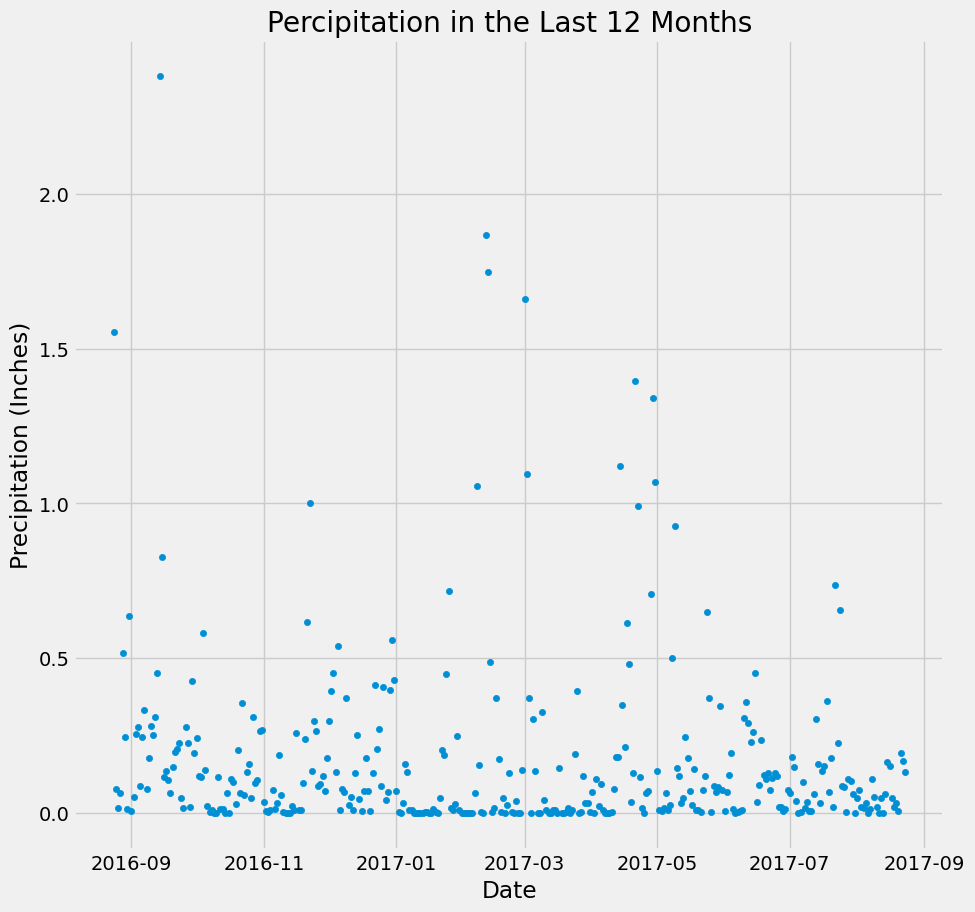

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Calculate the date one year from the last date in data set.
twelve_months = dt.datetime.strptime(recent_date,'%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
twelve_months_data = session.query(hawaii_measurement.date,func.avg(hawaii_measurement.prcp)).filter(hawaii_measurement.date > twelve_months).group_by(hawaii_measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
frame = pd.DataFrame(twelve_months_data,columns=['Date','Percipitation'])
frame['Date'] = pd.to_datetime(frame['Date'])
# Use Pandas Plotting with Matplotlib to plot the data
plot = frame.plot(kind='scatter',figsize = (10,10),x='Date',y='Percipitation')
plt.title('Percipitation in the Last 12 Months')
plt.ylabel('Precipitation (Inches)')
plt.xlabel('Date')
plt.savefig('Resources/PercipitationAnalysis.png')

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
frame.describe()

,Percipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
session.query(hawaii_stations.id).count()

9

In [30]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
station_data = session.query(hawaii_stations.name,hawaii_stations.station,func.avg(hawaii_measurement.prcp),func.count(hawaii_measurement.station)).filter(hawaii_stations.station == hawaii_measurement.station).group_by(hawaii_measurement.station).order_by(func.count(hawaii_measurement.station).desc()).limit(9).all()
# List the stations and their counts in descending order.
print(station_data)

[('WAIHEE 837.5, HI US', 'USC00519281', 0.21235209235209238, 2772), ('WAIKIKI 717.2, HI US', 'USC00519397', 0.04902048417132213, 2724), ('KANEOHE 838.1, HI US', 'USC00513117', 0.1419213649851631, 2709), ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 0.11496111975116645, 2669), ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 0.4299879227053139, 2612), ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 0.12105833763551888, 2202), ('HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 0.047971014492753594, 1979), ('PEARL CITY, HI US', 'USC00517948', 0.06360175695461198, 1372), ('UPPER WAHIAWA 874.3, HI US', 'USC00518838', 0.2072222222222222, 511)]


In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_name = session.query(hawaii_stations.name,hawaii_stations.station,func.avg(hawaii_measurement.prcp),func.count(hawaii_measurement.station)).filter(hawaii_stations.station == hawaii_measurement.station).group_by(hawaii_measurement.station).order_by(func.count(hawaii_measurement.station).desc()).first().name
print(active_name)

average = session.query(hawaii_stations.name,func.max(hawaii_measurement.tobs),func.min(hawaii_measurement.tobs),func.avg(hawaii_measurement.tobs)).filter(hawaii_stations.station == hawaii_measurement.station,hawaii_stations.name == active_name).all()
print(average)

WAIHEE 837.5, HI US
[('WAIHEE 837.5, HI US', 85.0, 54.0, 71.66378066378067)]


                 Station           id  precipitation  Temperature
0    WAIHEE 837.5, HI US  USC00519281           2.15         77.0
1    WAIHEE 837.5, HI US  USC00519281           0.06         80.0
2    WAIHEE 837.5, HI US  USC00519281           0.01         80.0
3    WAIHEE 837.5, HI US  USC00519281           0.12         75.0
4    WAIHEE 837.5, HI US  USC00519281           0.60         73.0
..                   ...          ...            ...          ...
346  WAIHEE 837.5, HI US  USC00519281           0.00         77.0
347  WAIHEE 837.5, HI US  USC00519281           0.32         77.0
348  WAIHEE 837.5, HI US  USC00519281           0.12         76.0
349  WAIHEE 837.5, HI US  USC00519281           0.01         76.0
350  WAIHEE 837.5, HI US  USC00519281           0.06         79.0

[351 rows x 4 columns]


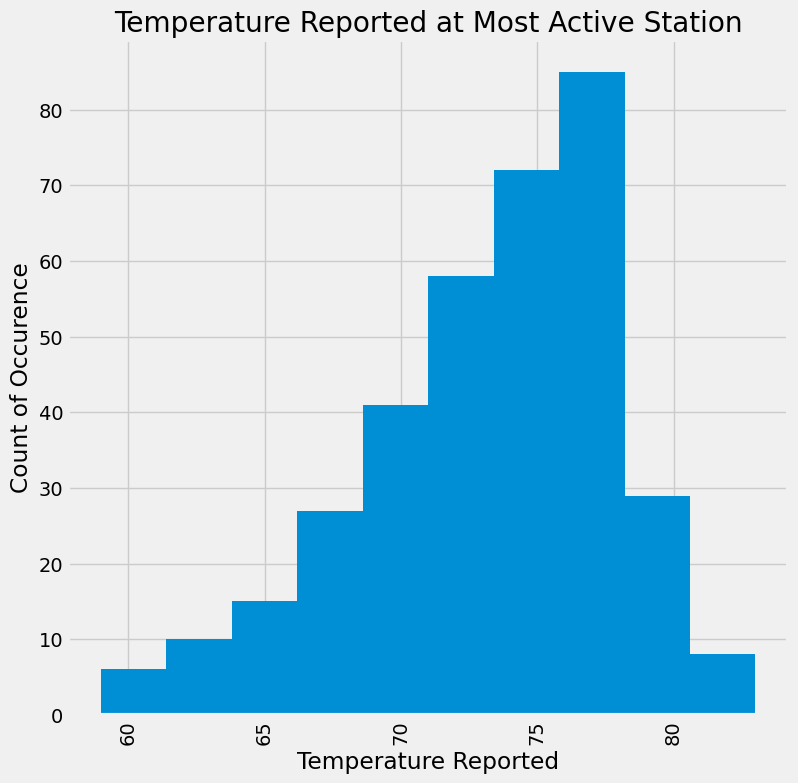

In [46]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_twelve_months = session.query(hawaii_stations.name,hawaii_stations.station,hawaii_measurement.prcp,hawaii_measurement.tobs).filter(hawaii_stations.station == hawaii_measurement.station,hawaii_stations.name==active_name,hawaii_measurement.date > twelve_months).all()
station_frame = pd.DataFrame(station_twelve_months,columns=['Station','id','precipitation','Temperature'])
print(station_frame)
station_frame.hist('Temperature',by='Station',bins=10,figsize=(9,9))
plt.title('Temperature Reported at Most Active Station')
plt.xlabel('Temperature Reported')
plt.ylabel('Count of Occurence')
plt.savefig('Resources/stationanalysis.png')

# Close Session

In [47]:
# Close Session
session.close()